### Time Series models for Stock Price Prediction
#### Will be using RNN, LSTM, GRU

In [1]:

# Copyright 2023 Shane Khalid. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
import yfinance as yf

import tensorflow as tf
from tensorflow import keras

from keras.layers import GRU, Dropout, SimpleRNN, LSTM, Dense, SimpleRNN, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

import pandas as pd
import numpy as np

import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from keras.metrics import Accuracy
from keras.metrics import F1Score
from keras.metrics import Precision


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import f1_score

%matplotlib inline

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from pmdarima import auto_arima
from prophet import Prophet
#from fbprophet import Prophet
#from fbprophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta

2023-10-30 18:49:19.141314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 18:49:19.141400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 18:49:19.141449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 18:49:19.157450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 18:49:21.923528: I tensorflow/compiler/

Num GPUs Available:  1
GPU is available and being used.


In [3]:
googl_df = yf.download("GOOGL", start="2010-01-01", end="2023-10-30")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']]
googl_df

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2010-01-04,15.684434,15.689439,15.753504,15.621622,15.684434,78169752
2010-01-05,15.615365,15.695195,15.711712,15.554054,15.615365,120067812
2010-01-06,15.221722,15.662162,15.662162,15.174174,15.221722,158988852
2010-01-07,14.867367,15.250250,15.265265,14.831081,14.867367,256315428
2010-01-08,15.065566,14.814815,15.096346,14.742492,15.065566,188783028
...,...,...,...,...,...,...
2023-10-23,136.500000,135.039993,137.660004,133.949997,136.500000,26317900
2023-10-24,138.809998,137.830002,139.360001,137.419998,138.809998,44814300
2023-10-25,125.610001,128.160004,128.309998,125.070000,125.610001,84366200


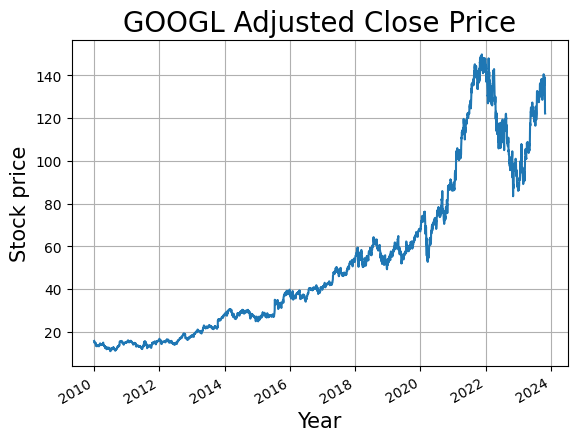

In [4]:
# Plot Adjusted Close price

googl_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('GOOGL Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

#### We will be generating multiple inputs and output data for training in order to forecast the future. Prices of the past 5 days (multiple inputs of 5 data points) to forecast prices of next 2 days (multiple outputs of 2 data points). 

#### We create **samples** from the univariate time series data and each sample has 5 inputs and 2 outputs. Each input is called **time step** and each time step has 1 feature - the Adjusted Close price. 

#### 1. Create training set using 70% of data and test set using 30%
#### 2. Normalize training data by converting values of numeric columns in dataset to common scale - like scikit-learn's minmaxscale function scales values to between 0 and 1
#### 3. create multiple input to output data structures for training and convert to numpy arrays for modeling
#### 4. reshape X_train data into 3D array with samples, time steps, feature dimensions
#### 5. create X_test data converting it to numpy array and reshapes into 3D array

In [15]:
# standardize data to train model - only the training data are used to fit the scaler transformation
# then the scaler is used to transform the test input data

def ts_train_test(data,time_steps,for_periods):
    '''
    Create training and test sets, scale data

    :param data: dataframe with dates and price data
    :param time_steps: number of input time steps
    :param for_periods: number of output time steps

    :returns: X_train, y_train: data from 2010-2020
              X_test:  data from 2021-2023
              sc: instantiated MinMaxScaler object fit to the training data
    '''
    # Create training and test set
    ts_train = googl_df[:'2020'].iloc[:,0:1].values
    ts_test  = googl_df['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Feature scaling - data normalization - only the training data are used to fit the scaler transformation
    # MinMaxScaler scales all the data to be between 0 and 1.
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of samples and time steps
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    # Convert X_train and y_train to numpy arrays for training
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train to 3-D array of samples, time steps and features for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing to create X_test
    inputs = pd.concat((googl_df["Adj Close"][:'2020'], googl_df["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Creating X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    # Convert X_test to numpy array    
    X_test = np.array(X_test)
    # Reshape X_test to be 3-D
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

X_train, y_train, X_test, sc = ts_train_test(googl_df,5,2) # Each sample row in X_train has 5 inputs and y_train has 2 outputs
X_train.shape[0],X_train.shape[1]                        # as we are using the prices of 5 days to forecast the prices of the ne

(2763, 5)

In [16]:
# Convert the 3-D shape of X_train and y_train to a data frame 
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_df = pd.DataFrame(y_train)
pd.concat([X_train_df,y_train_df],axis=1)

,0,1,2,3,4,0,1
0,0.059398,0.058538,0.053638,0.049227,0.051694,0.051411,0.048100
1,0.058538,0.053638,0.049227,0.051694,0.051411,0.048100,0.047043
2,0.053638,0.049227,0.051694,0.051411,0.048100,0.047043,0.047903
3,0.049227,0.051694,0.051411,0.048100,0.047043,0.047903,0.044835
4,0.051694,0.051411,0.048100,0.047043,0.047903,0.044835,0.047209
...,...,...,...,...,...,...,...
2758,0.957815,0.947433,0.938539,0.943730,0.934805,0.939790,0.943481
2759,0.947433,0.938539,0.943730,0.934805,0.939790,0.943481,0.968252
2760,0.938539,0.943730,0.934805,0.939790,0.943481,0.968252,0.958169
2761,0.943730,0.934805,0.939790,0.943481,0.968252,0.958169,0.944782


In [17]:
# Convert the 3-D shape of X_test to a data frame
X_test_df = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_df)

,0,1,2,3,4
0,0.943481,0.968252,0.958169,0.944782,0.954983
1,0.968252,0.958169,0.944782,0.954983,0.938483
2,0.958169,0.944782,0.954983,0.938483,0.947147
3,0.944782,0.954983,0.938483,0.947147,0.936460
4,0.954983,0.938483,0.947147,0.936460,0.968489
...,...,...,...,...,...
703,1.594025,1.573984,1.595643,1.603361,1.581453
704,1.573984,1.595643,1.603361,1.581453,1.578839
705,1.595643,1.603361,1.581453,1.578839,1.552076
706,1.603361,1.581453,1.578839,1.552076,1.563279


In [18]:
# Print number of samples
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 2763 samples in the training data
There are 708 samples in the test data


### RNN Model
#### Two recurrent layers with 32 neurons, input shape of data with number of time steps (5) and dimensionality (1) and an output later with time step of 2. Using default hyperbolic tangent activation function (tanh). Loss function is mean squared error and RMSprop (root mean square propagation) optimizer, then fitter to training set with 200 epochs and batch size of 150. 
##### Loss function is metric that measures errors between actual and predicted values, optimizer algo changes weights of neurons to pursue minimum error.

In [19]:
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    Create RNN model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    '''
    # The RNN architecture
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1],1)))  
    my_rnn_model.add(SimpleRNN(32))
    # The output layer
    my_rnn_model.add(Dense(2)) # The time step of the output is 2

    # Compiling the RNN model
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics = ['MAE', 'MAPE', 'F1Score', 'Accuracy', 'Precision']) 

    # Fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)

    # Make Predictions using the test set
    rnn_predictions = my_rnn_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions[1:10]

23/23 [==============================] - 0s 4ms/step


array([[85.64819 , 85.961235],
       [86.04586 , 86.30613 ],
       [85.25646 , 85.58636 ],
       [87.56596 , 87.76093 ],
       [88.73998 , 88.93832 ],
       [87.14906 , 87.36121 ],
       [85.57354 , 85.924126],
       [86.1658  , 86.51887 ],
       [85.96198 , 86.25411 ]], dtype=float32)

#### Calculate MSE and plot actual v. predicted prices

In [20]:
def actual_pred_plot(preds):
    '''
    Plot the actual vs. predicted prices

    :param preds: array of actual and predicted prices

    :returns: MSE score and plot of actual vs predicted prices
    '''
    # Create dataframe containing actual and predicted prices
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = googl_df.loc['2021':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    # Calculate mean squared error
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    print("MSE score:", m.result().numpy())

    # Plot actual vs predicted price
    sns.set(rc={'figure.figsize':(15, 9)})
    actual_pred.plot()
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
    plt.legend()

MSE score: 38.411102


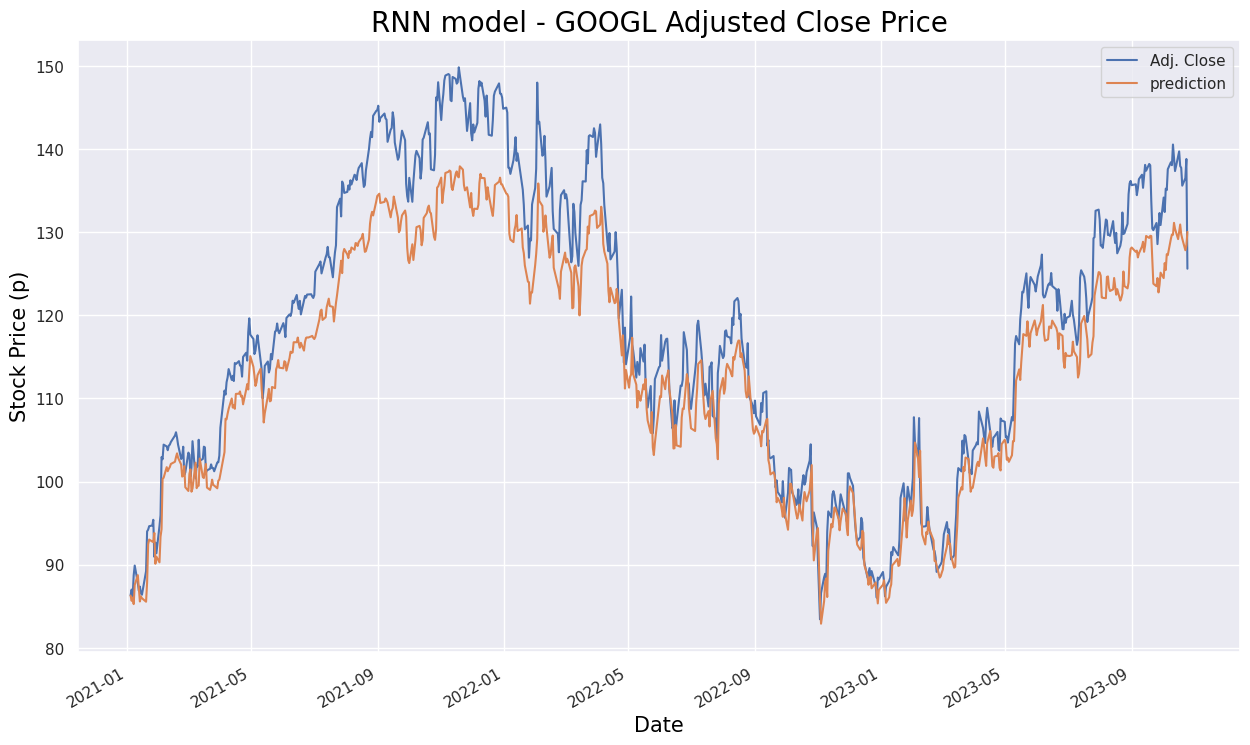

In [21]:
title_txt = 'RNN model - GOOGL Adjusted Close Price'

actual_pred_plot(rnn_predictions)


#### MSE of 38.4 which is pretty good. RNN's work by backpropagation when training and therefore at each step the gradient is being calculated and used to update weights. If the effect of the previous layer on the current layer is small, then the gradient value will be small. This can lead eventually to a vanishing gradient. I will next be using GRU and LSTM which are recursive models that shouldn't have this vanishing gradient problem.

### LSTM

#### LSTM retains memory of RNN for longer time periods. It introduces gates for controlling the flow of info entering into the NN. Gates themselves can learn which inputs are important and stores them in a memory unit. LSTM has input, output and forget gates. Going to implement this with two recurrent layers with 50 neurons, input shape of data with number of time steps (5) and dimensionality of 1, and output layer with time step fo 2, and tanh activation function. Drop-out will be used after the second hidden layer as a regularization technique to prevent overfitting. Compiled using MSE loss function, Adam optimizer, and 200 epochs with batch size of 150.

In [22]:
def LSTM_model(X_train, y_train, X_test, sc):  
    """
    Create LSTM model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    """
   
    # The LSTM architecture
    my_LSTM_model = Sequential()
    # First LSTM layer 
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # Second LSTM layer 
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # Dropout regularisation
    my_LSTM_model.add(Dropout(0.2))
    # The output layer
    my_LSTM_model.add(Dense(units=2)) 

    # Compiling the LSTM
    my_LSTM_model.compile(optimizer='adam',loss='mean_squared_error', metrics = ['MAE', 'MAPE', 'F1Score', 'Accuracy', 'Precision'])

    # Fitting the LSTM to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=200,batch_size=150, verbose=0)

    # Make Predictions using the test set
    LSTM_predictions = my_LSTM_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    LSTM_predictions = sc.inverse_transform(LSTM_predictions)

    return my_LSTM_model, LSTM_predictions

my_LSTM_model, LSTM_predictions = LSTM_model(X_train, y_train, X_test, sc)
LSTM_predictions[1:10]

23/23 [==============================] - 1s 4ms/step


array([[87.45622 , 87.51526 ],
       [87.23755 , 87.297554],
       [86.95665 , 87.01624 ],
       [87.403984, 87.46674 ],
       [88.255714, 88.31942 ],
       [88.555435, 88.61505 ],
       [88.29449 , 88.35034 ],
       [88.026955, 88.084656],
       [87.525085, 87.58446 ]], dtype=float32)

MSE score: 12.718576


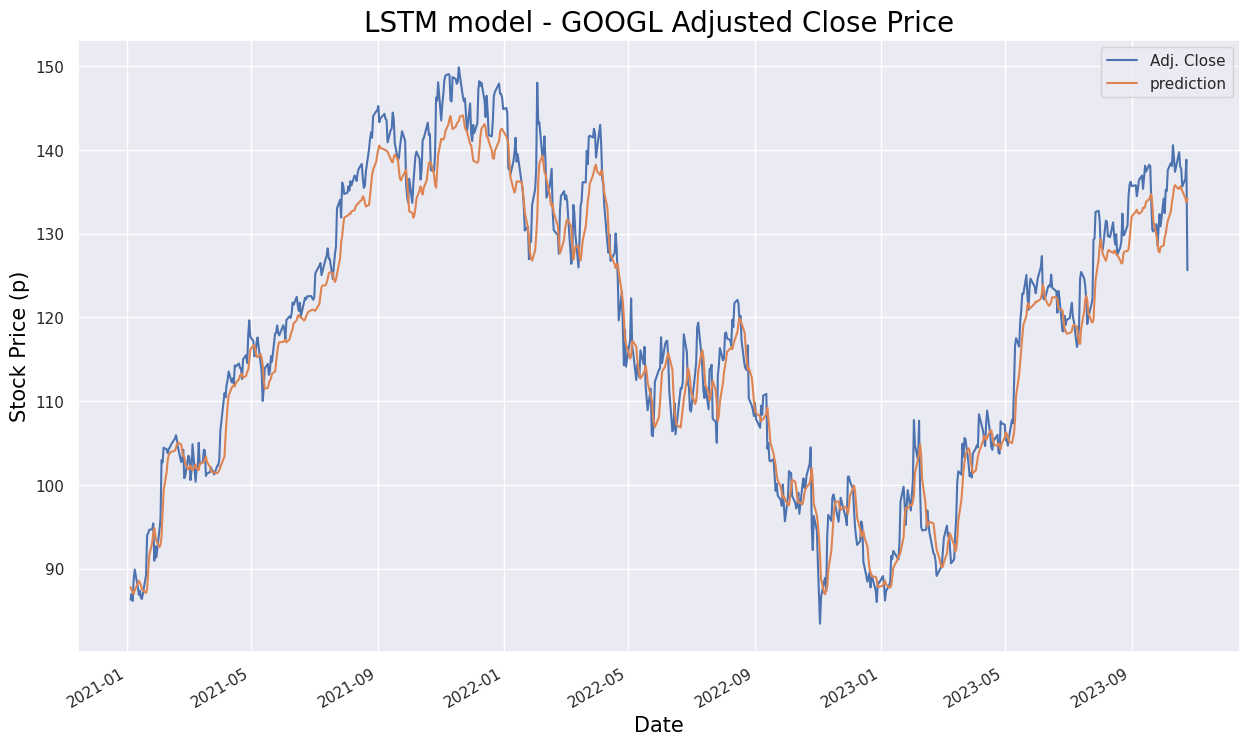

In [23]:
title_txt = 'LSTM model - GOOGL Adjusted Close Price'  

actual_pred_plot(LSTM_predictions)

#### Wow, this has an MSE of 12.72 (lower than 38.4 value of the RNN). Pretty good. Let's do one more, the GRU

### GRU - Gated Recurrent Units

##### Similar to LSTM in its aim to stop vanishing (or exploding) gradients. But does not use a cell state or an output gate like the LSTM, thus it has fewer parameters. It has hidden layers that transfer info and calls its two gates the reset gate and the update gate. 

##### Implementing this with 4 recurrent layers, 50 neurons, input shape of data with number of time steps (5) and dimensionality of 1, and output with time step of 2. Tanh function, dropout after each hidden layer to prevent overfitting. Same thing as before evaluation on MSE, adam optimizing, 200 epochs, batch size of 150.

In [24]:
def GRU_model(X_train, y_train, X_test, sc):  
    '''
    Create GRU model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: predictions on training data
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    '''

    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularization
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer with Dropout regularization
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Third GRU layer with Dropout regularization
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer with Dropout regularization
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))

    # The output layer
    my_GRU_model.add(Dense(units=2))

    # Compiling the GRU model
    my_GRU_model.compile(optimizer='adam',loss='mean_squared_error', metrics = ['MAE', 'MAPE', 'F1Score', 'Accuracy', 'Precision'])

    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=200,batch_size=150, verbose=0)

    # Make Predictions using the test set
    GRU_predictions = my_GRU_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_predictions = GRU_model(X_train, y_train, X_test, sc)
GRU_predictions[1:10]

23/23 [==============================] - 1s 6ms/step


array([[85.50372 , 85.58731 ],
       [85.42845 , 85.514725],
       [85.07022 , 85.154205],
       [85.92248 , 86.01695 ],
       [86.851   , 86.95285 ],
       [86.58781 , 86.679634],
       [86.11666 , 86.19988 ],
       [86.10772 , 86.19226 ],
       [85.616554, 85.700516]], dtype=float32)

MSE score: 44.506542


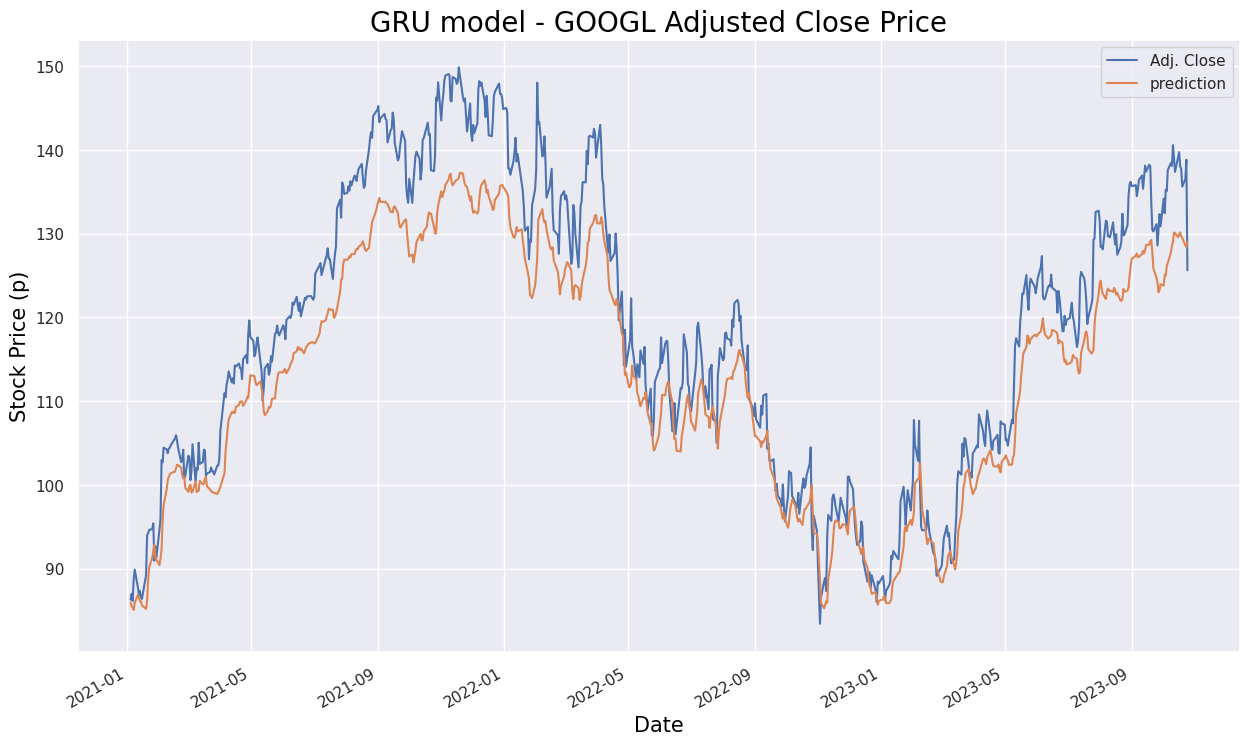

In [25]:
title_txt = 'GRU model - GOOGL Adjusted Close Price'   

actual_pred_plot(GRU_predictions) 

#### Hmm.. MSE of 44.5. This is the worst one and LSTM seems to be best. 